In [1]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import spacy
import unicodedata
import en_core_web_sm
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from textblob import TextBlob
import random

In [2]:
df=pd.read_csv('/Users/anagha/Desktop/Sentiment Analysis/Womens Clothing E-Commerce Reviews.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anagha/Desktop/Sentiment Analysis/Womens Clothing E-Commerce Reviews.csv'

# Data Cleaning

In [1]:
df.drop(['Age','Clothing ID', 'Division Name', 'Department Name', 'Class Name', 'Unnamed: 0'], axis = 1, inplace=True)
df.reset_index(inplace=True)
index_names = df[df['Review Text'].isnull() & df['Title'].isnull()].index 
df.drop(index_names, inplace = True) 
idx=df[df['Review Text'].isnull()].index
df['Review Text'][idx]=df['Title'][idx]
df.drop(['Title'],axis = 1, inplace=True)

NameError: name 'df' is not defined

# Text Preprocessing

In [5]:
# Converting into unicode format
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

df['Review Text Precrocessed']=df['Review Text'].apply(lambda x: strip_accents(x))


# Correcting the spelling using textblob
def spell_check(x):
    x=TextBlob(str(x)).correct()
    return ''.join(x)

df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: spell_check(x))


# Removing all the spaces
def remove_sapce(x):
    x=' '.join(x.split())
    return x
df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: remove_sapce(x))


# Converting in lower cases
df['Review Text Precrocessed']=df['Review Text Precrocessed'].str.lower()

# Expanding the contracted words 
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"i'm": "i am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

for key, value in contractions.items():
  key= key.lower()
  value=value.lower()
  
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value=contractions[key]
            x=x.replace(key,value)
        return x
    return x
df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: cont_to_exp(x))


# Removing Puntuation 
def puntuation_removal(x):
    x=re.sub(r'[^\w]+', " ", x)
    return x

df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: puntuation_removal(str(x)))

In [6]:
df.head(10)

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed
0,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,absolutely wonderful silky and sexy and comfor...
1,1,Love this dress! it's sooo pretty. i happene...,5,1,4,love this dress it is sooo pretty i happened t...
2,2,I had such high hopes for this dress and reall...,3,0,0,i had such high hopes for this dress and reall...
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,i love love love this jumpsuit it is fun flirt...
4,4,This shirt is very flattering to all due to th...,5,1,6,this shirt is very flattering to all due to th...
5,5,"I love tracy reese dresses, but this one is no...",2,0,4,i love tracy reese dresses but this one is not...
6,6,I aded this in my basket at hte last mintue to...,5,1,1,i aded this in my basket at hte last mintue to...
7,7,"I ordered this in carbon for store pick up, an...",4,1,4,i ordered this in carbon for store pick up and...
8,8,I love this dress. i usually get an xs but it ...,5,1,0,i love this dress i usually get an xs but it r...
9,9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,i am 5 5 and 125 lbs i ordered the s petite to...


In [7]:
df['Review Text Precrocessed']

0        absolutely wonderful silky and sexy and comfor...
1        love this dress it is sooo pretty i happened t...
2        i had such high hopes for this dress and reall...
3        i love love love this jumpsuit it is fun flirt...
4        this shirt is very flattering to all due to th...
5        i love tracy reese dresses but this one is not...
6        i aded this in my basket at hte last mintue to...
7        i ordered this in carbon for store pick up and...
8        i love this dress i usually get an xs but it r...
9        i am 5 5 and 125 lbs i ordered the s petite to...
10       dress runs small esp where the zipper area run...
11       this dress is perfection so pretty and flatter...
12       more and more i find myself reliant on the rev...
13       bought the black xs to go under the larkspur m...
14       this is a nice choice for holiday gatherings i...
15       i took these out of the package and wanted the...
16       material and color is nice the leg opening is .

# Tokennization

In [8]:
def tokenize(x):
    x= TextBlob(str(x)).words
    return x

# Lemmatization

In [9]:
nlp = spacy.load('en_core_web_sm')
def make_to_base(x):
    x_list=[]
    doc=nlp(x)
    for token in doc:
        lemma=token.lemma_
        
        if lemma=='_PRON_' or lemma == 'be' or lemma == 'is': 
            lemma=token.text
            
        x_list.append(lemma)
    return ' '.join(x_list)

df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: make_to_base(x.decode("utf-8")))

In [10]:
df.head(10)

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed
0,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,absolutely wonderful silky and sexy and comfor...
1,1,Love this dress! it's sooo pretty. i happene...,5,1,4,love this dress -PRON- is sooo pretty i happen...
2,2,I had such high hopes for this dress and reall...,3,0,0,i have such high hope for this dress and reall...
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,i love love love this jumpsuit -PRON- is fun f...
4,4,This shirt is very flattering to all due to th...,5,1,6,this shirt is very flattering to all due to th...
5,5,"I love tracy reese dresses, but this one is no...",2,0,4,i love tracy reese dress but this one is not f...
6,6,I aded this in my basket at hte last mintue to...,5,1,1,i ad this in -PRON- basket at hte last mintue ...
7,7,"I ordered this in carbon for store pick up, an...",4,1,4,i order this in carbon for store pick up and h...
8,8,I love this dress. i usually get an xs but it ...,5,1,0,i love this dress i usually get an xs but -PRO...
9,9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,i am 5 5 and 125 lb i order the s petite to ma...


# Label Generation

In [11]:
def la(x):
    if(x>3):
        return 1
    else:
        return 0
    
df['Label']=df['Rating'].apply(lambda x:la(x))
Positive_review_1=[]
Negative_review_1=[]
Positive_review_1=df[df['Label']==1]
Negative_review_1=df[df['Label']==0]


In [12]:
def label(x):
    if(x>3):
        return 1
    elif(x==3):
        return 2
    else:
        return 0

df['Label_3C']=df['Rating'].apply(lambda x:label(x))
Positive_review=[]
Negative_review=[]
Neutral_review=[]
Positive_review=df[df['Label_3C']==1]
Negative_review=df[df['Label_3C']==0]
Neutral_review=df[df['Label_3C']==2]


# TFIDF Vector Generation

In [13]:
stopwords = ['a', 'about', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you','-PRON-','pron']


from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words=stopwords, tokenizer= tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)
X=tfidf.fit_transform(df['Review Text Precrocessed'])
X.shape

(22642, 49458)

In [14]:
yes=pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
yes.head(5)

,0,0 00,0 109lbs,0 110,0 120,0 125,0 2,0 5,0 am,0 because,...,zipper stick,zipper style,zipper up,zipper very,zipper well,zipper work,zipper would,zipper zip,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Splitting Data

In [15]:
y=df['Label']
X=X
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=.20,random_state=0)

# ROC and Confusion Matrix

In [16]:
def get_ROC(y_test, y_pred):
    
    # Compute ROC and plot curve
    
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
def get_ROC_multiclass(y_test, y_pred):
    
    #Compute ROC and plot curve for three classes
    
    n_classes=3
    # roc curve
    fpr = dict()
    tpr = dict()
    aucroc=dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
        aucroc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label='class {} (AUC = {:0.2f})'.format(i, aucroc[i] ))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()


def get_Confusion_Matrix(y_test, y_pred):
    
    # Compute and plot Confusion Matrix 
    
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels='auto', yticklabels='auto')
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()
    

# Random Forest

## Binary Classification

[[ 435  626]
 [ 146 3322]]
             precision    recall  f1-score   support

          0       0.75      0.41      0.53      1061
          1       0.84      0.96      0.90      3468

avg / total       0.82      0.83      0.81      4529

Accuracy Score: 0.829542945463
F1 Score: 0.895900755124


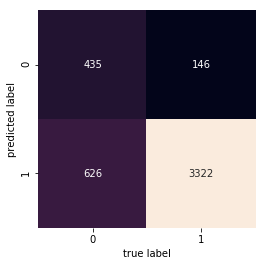

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


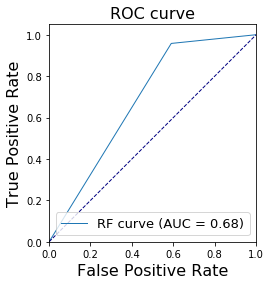

In [32]:
def RandomForestBinaryClassifier(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier()
    
    # Training model
    rfc.fit(X_train, y_train)
    
    # Prediction using model
    y_pred = rfc.predict(X_test)
    
    # Validating the data
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    Classification_report = classification_report(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    Accuracy_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, y_pred)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, y_pred)
    
    get_Confusion_Matrix(y_test, y_pred)
    
    get_ROC(y_test, y_pred)
    

RandomForestBinaryClassifier(X_train, y_train, X_test, y_test)

# Binary Classification with Hyperparameter Tuning

[[ 540  521]
 [ 195 3273]]
             precision    recall  f1-score   support

          0       0.73      0.51      0.60      1061
          1       0.86      0.94      0.90      3468

avg / total       0.83      0.84      0.83      4529

Accuracy Score: 0.841907705895
F1 Score: 0.901404571743


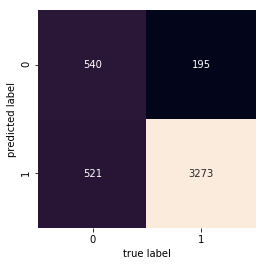

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


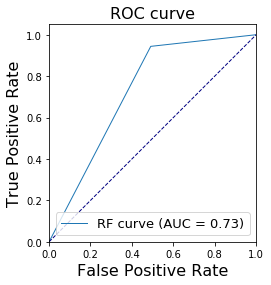

In [44]:
# class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2,
#                                               min_samples_leaf=1, max_features='auto')
                  
rfc_tuned = RandomForestClassifier(min_samples_leaf = 1, n_estimators =25, min_samples_split =8, criterion= 'gini', max_features=25000, max_depth= 40)
def RandomForestBinaryClassifierTuned(X_train, y_train, X_test, y_test):
   
    # Training model
    rfc_tuned.fit(X_train, y_train)
    
    # Prediction using model
    y_pred = rfc_tuned.predict(X_test)
    
    # Validating the data
    
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    Classification_report = classification_report(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    Accuracy_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, y_pred)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, y_pred)
    
    get_Confusion_Matrix(y_test, y_pred)
    get_ROC(y_test, y_pred)
    
    
    
RandomForestBinaryClassifierTuned(X_train, y_train, X_test, y_test)

# Data Split for Three Classes

In [19]:
y_3c=df['Label_3C']
X_3c=X

X_train_3c, X_test_3c, y_train_3c, y_test_3c = train_test_split(X_3c ,y_3c ,test_size=.20, random_state=0)
print(df['Label_3C'].value_counts())

1    17449
2     2823
0     2370
Name: Label_3C, dtype: int64


In [20]:
y_dummy=label_binarize(y_3c, classes=[0,1,2])
X_3c=X

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_3c, y_dummy ,test_size=.20, random_state=0)

## Random Forest for Three Classes

Build random Forest Classifier 
[[  76  387   32]
 [  13 3441   14]
 [  34  514   18]]
             precision    recall  f1-score   support

          0       0.62      0.15      0.25       495
          1       0.79      0.99      0.88      3468
          2       0.28      0.03      0.06       566

avg / total       0.71      0.78      0.71      4529

Accuracy Score: 0.780525502318
F1 Score: 0.708769188348


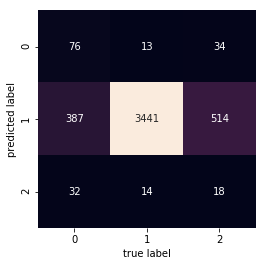

(18113, 49458)
(18113, 3)


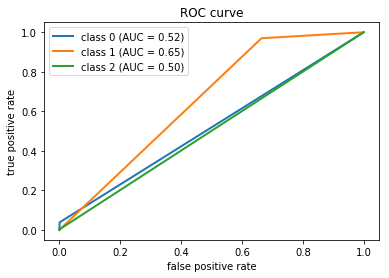

In [65]:
print("Build random Forest Classifier ")

def RandomForest_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c):  
    rfc_3c = RandomForestClassifier()
    # Training model
    
    rfc_3c.fit(X_train_3c, y_train_3c)
    
    # Prediction using model
    
    y_pred_3c = rfc_3c.predict(X_test_3c)
    
    # Validating the data
    
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='weighted')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    
def RandomForest_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy):
    print(X_train_dummy.shape)
    print(y_train_dummy.shape)
    rfc_3c.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = rfc_3c.predict(X_test_dummy)
    
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    
RandomForest_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c)  
RandomForest_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)

## Random Forest for Three Classes with Hyperparameter Tuning

Build random Forest Classifier 
[[ 133  289   73]
 [  58 3331   79]
 [  81  382  103]]
             precision    recall  f1-score   support

          0       0.49      0.27      0.35       495
          1       0.83      0.96      0.89      3468
          2       0.40      0.18      0.25       566

avg / total       0.74      0.79      0.75      4529

Accuracy Score: 0.787591079709
F1 Score: 0.75216741296


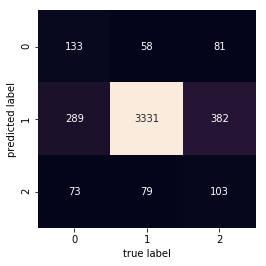

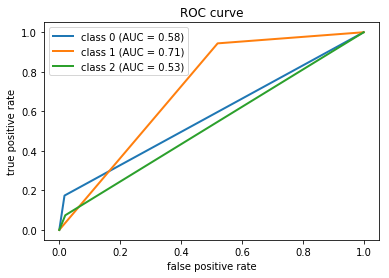

In [66]:
print("Build random Forest Classifier ")
rfc_3c_tuned = RandomForestClassifier(min_samples_leaf = 2, n_estimators =15, min_samples_split =8, criterion= 'gini', max_features=25000, max_depth= 39)
# class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2,
#                                               min_samples_leaf=1, max_features='auto')

def RandomForest_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c): 
    
    # Training model
    
    rfc_3c_tuned.fit(X_train_3c, y_train_3c)
    
    # Prediction using model
    
    y_pred_3c = rfc_3c_tuned.predict(X_test_3c)
    
    # Validating the data
    
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='weighted')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    

def RandomForest_ThreeClass_Tuned_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy):
    rfc_3_tuned = RandomForestClassifier(min_samples_leaf = 2, n_estimators =15, min_samples_split =8, criterion= 'gini', max_features=25000, max_depth= 39)
    rfc_3_tuned.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = rfc_3_tuned.predict(X_test_dummy)
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    
RandomForest_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c)  
RandomForest_ThreeClass_Tuned_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)

# Testing

In [37]:
#negative sentiment indices
Negatives=df[df['Label']==0].index.tolist()

#positive sentiment indices
Positives=df[df['Label']==1].index.tolist()

#neutral sentiment indices
Neutral=df[df['Label_3C']==2].index.tolist()

In [ ]:
## Positive Review Testing

In [49]:
val=random.choice(Positives)
Test_sentence = df.loc[ (df['Label'] == 1) & (df['index'] == val) , 'Review Text']

In [ ]:
## Negative Review Testing

In [ ]:
val=random.choice(Negatives)
Test_sentence = df.loc[ (df['Label'] == 0) & (df['index'] == val) , 'Review Text']

In [ ]:
## Neutral Review testing

In [61]:
val=random.choice(Negatives)
Test_sentence = df.loc[ (df['Label_3C'] == 2) & (df['index'] == val) , 'Review Text']

In [ ]:
## Test Your Own Sentence

In [ ]:
Test_sentence =["This dress is very good but color is bad"]

In [ ]:
## Test According to Customer ID

In [ ]:
Test_sentence = df.loc[df['index'] == 10 , 'Review Text']

In [62]:
Test_sentence

19398    Cute sweater, i really like the grey color. unfortunately, it was boxy and a little short on me. almost worth keeping, but even with a t-shirt underneath, i wanted to scratch my skin off. it's very itchy. mine is going back.
Name: Review Text, dtype: object

In [63]:
pd.set_option('display.max_colwidth', 1000)
print("Original Review")
print(Test_sentence)
print("\n")


print("Actual Label")
Actual_label= df.loc[df['index'] == val , 'Label']
print(Actual_label)
print("\n")

def prediction(x):
    x=df.loc[df['index'] == val , 'Review Text Precrocessed']
    X=tfidf.transform(x)
    pred=rfc_tuned.predict(X)
    if pred==0:
      return 'Negative'
    else:
      return 'Positive'

prediction(Test_sentence)

Original Review
19398    Cute sweater, i really like the grey color. unfortunately, it was boxy and a little short on me. almost worth keeping, but even with a t-shirt underneath, i wanted to scratch my skin off. it's very itchy. mine is going back.
Name: Review Text, dtype: object


Actual Label
19398    0
Name: Label, dtype: int64




'Negative'

In [64]:
def prediction_3_class(x):
    x=df.loc[df['index'] == val , 'Review Text Precrocessed']
    X=tfidf.transform(x)
    pred=rfc_3c_tuned.predict(X)
    if pred==0:
      return 'Negative'
    elif pred==2:
        return 'Neutral'
    else:
      return 'Positive'
prediction_3_class(Test_sentence)

'Neutral'